#  MelodyMaster
## Notebook02 - Representations, Metrics and kNN
### Idan Kashani & Or Raphael Bidusa

# Welcome Back!
Today we shall build our first classifier, using the already preprocessed data from part 1.
Make sure to run part 1 in order to get the right csv files, you can run `script01.py` instead of the notebook itself.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import ast
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
np.random.seed(42)

First, we will load the dataset.

In [3]:
train_df = pd.read_csv('./train.csv')
print(f'train shape: {train_df.shape}')

train shape: (8496, 6)


## Vocabulary is Key
Each song in our dataset will be represented and embedded in three different ways, Bag-of-Words, Set-of-Words and TF-IDF.
In order to create these representations we need to work with a *vocabulary* - a set of all the words in the training set.

In [4]:
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l))))
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
print(vocabulary)
print(f"Vocabulary length is: {len(vocabulary)}")

["'א", "'אבי", "'אבל'", "'אהבה'", "'אוי", "'איגן'", "'אין'", "'אל", "'אמא", "'אנא", "'אנחנו", "'אני", "'בוא'", "'בואי", "'בואי'", "'בוואלה'", "'בטיח", "'בעד", "'בעד'", "'בראבו'", "'ה", "'הבן", "'הגדולה'", "'הו", "'הוא", "'השיר", "'זה", "'חד", "'חפף", "'חריסולה'", "'חת", "'טוב", "'טיליגנטי", "'יהי", "'ילדי", "'ך", "'כוכב", "'כי", "'כן'", "'כנס", "'לא", "'לבלות'", "'לימלך", "'לכה", "'מונאמי'", "'נגד'", "'ני", "'נתגבר", "'סה", "'סחתן'", "'סתובבתי", "'סתכל", "'סתכלי", "'סתכלים", "'עגלה", "'עוד", "'על", "'ענני", "'פירסט", "'צ'זבטי'", "'צ'יזבט'", "'קבורה'", "'קכ", "'קכ'קכ'", "'רכבה'", "'רע'", "'שבעה'", "'שהחיינו'", "'שחק", "'שלום", "'שמפיין'", "'שק", "'תגיד", "'תה", "'תו", "'תודה", "'תושיה'", "'תי", "'תיישבתי", "'תיקוה", "'תלב", "'תם", "'תמיד'", '16אף', 'Blצder', 'FLOW', 'Fuckin', 'JDים', 'Libertא', 'beat', 'frבher', 'wהr', "א'", "א'פחד", 'אאאהה', 'אאבד', 'אאבדך', 'אאבק', 'אאדיר', 'אאהאאה', 'אאההה', 'אאוט', 'אאונץ', 'אאזין', 'אאחל', 'אאחר', 'אאלבי', 'אאלץ', 'אאמין', 'אאמינה', 'אאמץ', 'אאסוף'

## Bag-of-Words Representation
The first representation of a sample in the dataset will be the Bag-of-Words representation (BoW).
In BoW, each song is represented by a vector in the size of the vocabulary.
The i-th entry in the vector contains the number of times the corresponding i-th word in the vocabulary appeared in the song.
For example, if the following lines were a complete song:

`טוליק, הי טוליק, תן לי עינב`
`אך טוליק שותק, כמעט נעלב`

They would be represented by a vector from the size of 56940 (the size of the vocabulary).
The entry which represents the word `טוליק` would have the value of 3 and all the other words with the value of 1.

As you can infer, the vectors are going to be sparse, and therefore we will use <class 'scipy.sparse._csr.csr_matrix'> for storing them.
This class will help us with doing arithmetic operations efficiently, using the fact that the vectors are sparse.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bow = CountVectorizer(vocabulary=vocabulary)
BoW_train = vectorizer_bow.fit_transform(train_df.lyrics)
print(f"The size of the vocabulary is indeed: {len(vectorizer_bow.get_feature_names_out())}")

The size of the vocabulary is indeed: 62178


Let's look upon the song `טוליק` by the artist `אושיק לוי`.
By manually counting, the word `טוליק` appears 8 times, the word `יושב` appears 4 times and the word `רינה` only once.

In [6]:
def word_count(v,w):
    print(f"The word {w} appears {v[0,vocabulary.index(w)]} times")

tulik_bow = BoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_bow,'טוליק')
word_count(tulik_bow,'יושב')
word_count(tulik_bow,'רינה')

The word טוליק appears 8 times
The word יושב appears 4 times
The word רינה appears 1 times


## Set-of-Words Representation
A bit less complicated representations is the Set-of-Words (SoW).
Instead of a counter for each word in the vocabulary there's an index - whether the word appears in the song or not regardless of quantity.
Although less informative, according to [Jurafsky and Martin](http://web.stanford.edu/~jurafsky/slp3/), somtimes SoW representation does better with classification than BoW does.
We will try both of the embeddings and determine which one is better using the validation set.


In [7]:
vectorizer_sow = CountVectorizer(vocabulary=vocabulary, binary=True)
SoW_train = vectorizer_sow.fit_transform(train_df.lyrics)
tulik_sow = SoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_sow,'טוליק')
word_count(tulik_sow,'יושב')
word_count(tulik_sow,'רינה')

The word טוליק appears 1 times
The word יושב appears 1 times
The word רינה appears 1 times


## tf-idf Representation
[term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) representation is a statistical tool that represents the importance of a word in a text.
The value increases proportionally to the number of times a word appears in the songs, like BoW, but offsets by the number of songs that contain the word.
This puts emphasis on words that "represent" the song best, considering both the number of times the word appears (tf) but also the uniqueness of the word (idf).
In the following example, even tho `של` appears 3 times more than `האשכול`, the word `האשכול` is way more unique considering how common the word `של` is in the corpus.
Therefore, the idf value of `של` is way smaller, and as a result, a smaller value of tf-idf value altogether.

In [8]:
def tfidf_value(v,w):
    print(f"The word {w} has a tf-idf value of: {v[0,vocabulary.index(w)]}")

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(vocabulary=vocabulary,sublinear_tf=True)
tfidf_train = vectorizer_tfidf.fit_transform(train_df.lyrics)
tulik_tfidf = tfidf_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_bow,'האשכול')
word_count(tulik_bow,'של')
tfidf_value(tulik_tfidf, 'האשכול')
tfidf_value(tulik_tfidf, 'של')

The word האשכול appears 1 times
The word של appears 3 times
The word האשכול has a tf-idf value of: 0.18829279566016882
The word של has a tf-idf value of: 0.08559306392759143


## On Cloud Nine
One great way of presenting the importance of words in a corpus is using the [Tag Cloud](https://en.wikipedia.org/wiki/Tag_cloud) diagram.
Although it required a protracted battle with libraries that refuse to support the Hebrew language, we manged to plot tag clouds diagrams for each of the three representations of our corpus.

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

k_best_words = 100
bow_by_words = BoW_train.sum(axis=0)
sow_by_words = SoW_train.sum(axis=0)
tfidf_by_words = tfidf_train.mean(axis=0)
bow_inx = np.argsort(bow_by_words).tolist()[0][-k_best_words:]
sow_inx = np.argsort(sow_by_words).tolist()[0][-k_best_words:]
tfidf_inx = np.argsort(tfidf_by_words).tolist()[0][-k_best_words:]

#### Bag-of-Words Cloud
The first diagram represents the most common tokens, using the Bag-of-Words representation.
First in the entire corpus and then in `טוליק`.

Most common tokens (Bag-of-Words representation):
['את', 'לא', 'אני', 'לי', 'זה', 'כל', 'על', 'מה', 'אל', 'רק', 'עוד', 'הוא', 'לך', 'של', 'כמו', 'אם', 'יש', 'היא', 'גם', 'כבר', 'אז', 'עם', 'אתה', 'אין', 'איך', 'אותי', 'אותך', 'כי', 'הכל', 'עד', 'מי', 'כך', 'שלי', 'עכשיו', 'שוב', 'לו', 'לה', 'אחד', 'תמיד', 'רוצה', 'אבל', 'אולי', 'או', 'יום', 'שם', 'בלי', 'כמה', 'היה', 'אהבה', 'היום', 'טוב', 'יותר', 'הם', 'כאן', 'שלך', 'בין', 'שלא', 'איתך', 'להיות', 'פעם', 'פה', 'בא', 'בי', 'הלב', 'אך', 'כן', 'כולם', 'הזמן', 'הלילה', 'אוהב', 'קצת', 'למה', 'יודע', 'בתוך', 'אלי', 'יפה', 'לבד', 'פתאום', 'הייתי', 'בכל', 'יהיה', 'דבר', 'שיר', 'אחר', 'אותו', 'אור', 'שאת', 'יכול', 'אנחנו', 'הולך', 'אחת', 'אף', 'מן', 'איתי', 'שאני', 'העולם', 'לנו', 'הזה', 'אותה', 'לילה']


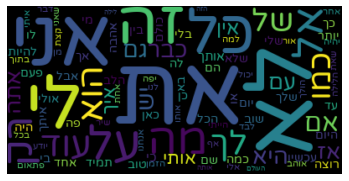

Most common tokens in טוליק (Bag-of-Words representation):
['טוליק', 'לו', 'יושב', 'של', 'על', 'בשקט', 'הכחול', 'מביט', 'הוא', 'הים', 'בחול', 'עגולות', 'העינב', 'לאכול', 'הי', 'ענבים', 'רינה', 'אוכל', 'כי', 'בעיניים', 'לי', 'העיניים', 'שני', 'רק', 'כוכבים', 'אשכול', 'האשכול', 'לה', 'כמעט', 'אך', 'לטוליק', 'דמעות', 'שותק', 'בנחת', 'כל', 'מותר', 'נעלב', 'הלכה', 'לבד', 'בחולות', 'עינב', 'תן']


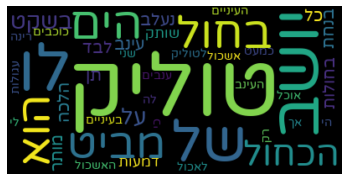

In [10]:
print("Most common tokens (Bag-of-Words representation):")
print([vocabulary[l] for l in bow_inx[::-1]])
bow_text= ""
for w in bow_inx:
    bow_text += (vocabulary[w][::-1]+" w ") * bow_by_words[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(bow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Most common tokens in טוליק (Bag-of-Words representation):")
bow_inx_tulik = np.argsort(tulik_bow.sum(axis=0)).tolist()[0][-tulik_sow.sum():]
print([vocabulary[l] for l in bow_inx_tulik[::-1]])
bow_text= ""
for w in bow_inx_tulik:
    bow_text += (vocabulary[w][::-1]+" w ") * tulik_bow.sum(axis=0)[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(bow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Set-of-Words Cloud
The second diagram represents the most common unique tokens (without repetitions), using the Set-of-Words representation.
How should a tag cloud for one song look like using the SoW representation?
Notice how the word `לי` was number 4 on the BoW list but number 6 on SoW?
The usage of the word might be more repetitive than song-wise-common, meaning the songs that used it, used it many times, which made it climb the BoW index.

Most common unique tokens (Set-of-Words representation):
['את', 'לא', 'אני', 'כל', 'על', 'לי', 'זה', 'רק', 'מה', 'אל', 'עוד', 'של', 'כמו', 'גם', 'לך', 'אם', 'כבר', 'עם', 'הוא', 'אז', 'יש', 'אין', 'איך', 'כי', 'כך', 'אותך', 'עד', 'אותי', 'הכל', 'עכשיו', 'היא', 'שוב', 'אבל', 'תמיד', 'אתה', 'אחד', 'שלי', 'לו', 'בלי', 'שם', 'מי', 'רוצה', 'אולי', 'אהבה', 'או', 'היום', 'יום', 'בין', 'יותר', 'כאן', 'שלא', 'היה', 'הלב', 'שלך', 'הם', 'כמה', 'להיות', 'טוב', 'אך', 'הזמן', 'לה', 'בי', 'פתאום', 'בתוך', 'פעם', 'איתך', 'קצת', 'פה', 'יודע', 'בא', 'יפה', 'בכל', 'לבד', 'אוהב', 'כולם', 'אחר', 'אלי', 'הלילה', 'דבר', 'כן', 'אור', 'מן', 'יהיה', 'אותו', 'העולם', 'אף', 'למה', 'שאת', 'אחת', 'שאני', 'יכול', 'מקום', 'איתי', 'שיר', 'אותה', 'הולך', 'לנו', 'בך', 'מול', 'החיים']


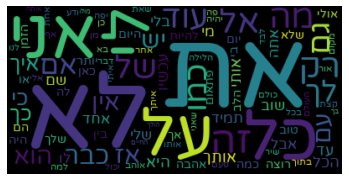

In [11]:
print("Most common unique tokens (Set-of-Words representation):")
print([vocabulary[l] for l in sow_inx[::-1]])
sow_text= ""
for w in sow_inx:
    sow_text += (vocabulary[w][::-1]+" w ") * sow_by_words[0,w]

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(sow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### it-idf Cloud
The third diagram represents the most 'important' words, using the tf-idf representation.
First in the entire corpus and then in `טוליק`.
Notice how the word `הים` was number 5 on the BoW representation of `טוליק` but number 15(!!!) on the tf-idf representation?


Most 'important' tokens (tf-idf representation):
['את', 'לא', 'אני', 'לי', 'כל', 'זה', 'על', 'מה', 'רק', 'אל', 'לך', 'עוד', 'כמו', 'אם', 'של', 'הוא', 'יש', 'כבר', 'גם', 'אותך', 'אין', 'איך', 'אז', 'היא', 'אתה', 'עם', 'אותי', 'כי', 'הכל', 'כך', 'עכשיו', 'עד', 'שלי', 'שוב', 'תמיד', 'רוצה', 'לו', 'מי', 'אחד', 'אולי', 'אבל', 'אהבה', 'בלי', 'יום', 'שם', 'כמה', 'היום', 'או', 'איתך', 'לה', 'שלך', 'היה', 'יותר', 'כאן', 'טוב', 'הלב', 'בין', 'להיות', 'בי', 'שלא', 'הם', 'פעם', 'אוהב', 'הזמן', 'הלילה', 'אך', 'בא', 'יודע', 'בתוך', 'לבד', 'אלי', 'פה', 'יפה', 'קצת', 'פתאום', 'כולם', 'כן', 'למה', 'בכל', 'שאת', 'דבר', 'אחר', 'אור', 'הייתי', 'יהיה', 'איתי', 'יכול', 'שיר', 'שאני', 'העולם', 'הולך', 'בך', 'אותו', 'אף', 'מקום', 'אחת', 'אותה', 'יודעת', 'מן', 'לנו']


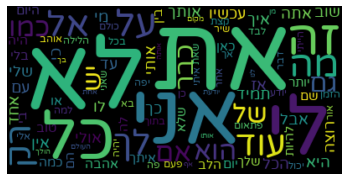

Most 'important' tokens in טוליק (tf-idf representation):
['טוליק', 'יושב', 'הכחול', 'העינב', 'האשכול', 'לטוליק', 'בחול', 'עגולות', 'עינב', 'אשכול', 'מביט', 'נעלב', 'בשקט', 'רינה', 'ענבים', 'בחולות', 'לו', 'בנחת', 'הים', 'לאכול', 'הי', 'הלכה', 'שותק', 'מותר', 'העיניים', 'כוכבים', 'אוכל', 'דמעות', 'בעיניים', 'תן', 'של', 'שני', 'כמעט', 'הוא', 'לבד', 'לה', 'אך', 'על', 'כי', 'רק', 'לי', 'כל']


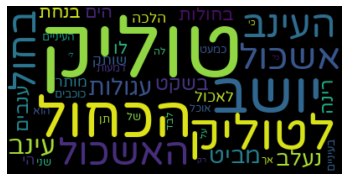

In [12]:
print("Most 'important' tokens (tf-idf representation):")
print([vocabulary[l] for l in tfidf_inx[::-1]])
tfidf_text= ""
for w in tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Most 'important' tokens in טוליק (tf-idf representation):")
tfidf_inx_tulik = np.argsort(tulik_tfidf.mean(axis=0)).tolist()[0][-tulik_sow.sum():]
print([vocabulary[l] for l in tfidf_inx_tulik[::-1]])
tfidf_text= ""
for w in tfidf_inx_tulik:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*tulik_tfidf.mean(axis=0)[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## tf-idf Cloud - Song Concatenation
Instead of taking the mean over all the songs, we will first concatenate the songs of each singer to one big song.

Most 'important' tokens (tf-idf representation) Using Songs Concatenation:
['את', 'לא', 'אני', 'לי', 'זה', 'כל', 'על', 'מה', 'אל', 'עוד', 'רק', 'כמו', 'לך', 'של', 'אם', 'הוא', 'יש', 'גם', 'כבר', 'אין', 'אז', 'היא', 'איך', 'עם', 'אותי', 'כי', 'אתה', 'אותך', 'עכשיו', 'הכל', 'עד', 'כך', 'מי', 'שוב', 'שלי', 'תמיד', 'אחד', 'רוצה', 'אולי', 'לו', 'אבל', 'לה', 'בלי', 'או', 'שם', 'יום', 'היום', 'כמה', 'כאן', 'יותר', 'אהבה', 'שלך', 'היה', 'שלא', 'בין', 'הם', 'להיות', 'פעם', 'טוב', 'בי', 'הזמן', 'קצת', 'הלב', 'בתוך', 'בא', 'איתך', 'הלילה', 'אלי', 'פה', 'לבד', 'יפה', 'יודע', 'הייתי', 'אוהב', 'כולם', 'בכל', 'פתאום', 'דבר', 'למה', 'אחר', 'כן', 'יהיה', 'אך', 'אף', 'יכול', 'אור', 'מקום', 'הולך', 'הזה', 'שאני', 'אותו', 'איתי', 'שאת', 'אחת', 'אותה', 'אנחנו', 'העולם', 'שיר', 'בואי', 'עלי']


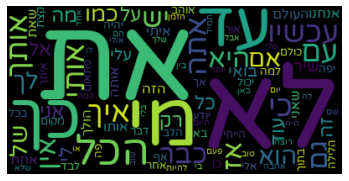

In [45]:
long_songs = train_df[['artist','lyrics']].groupby(train_df['artist']).aggregate({'lyrics': 'sum'}).reset_index()
vectorizer_tfidf_long = TfidfVectorizer(vocabulary=vocabulary,sublinear_tf=True)
tfidf_train_long = vectorizer_tfidf_long.fit_transform(long_songs.lyrics)
tfidf_by_words_long = tfidf_train_long.mean(axis=0)
tfidf_inx_long = np.argsort(tfidf_by_words_long).tolist()[0][-k_best_words:]

print("Most 'important' tokens (tf-idf representation) Using Songs Concatenation:")
print([vocabulary[l] for l in tfidf_inx_long[::-1]])
tfidf_text= ""
for w in tfidf_inx_long:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100*tfidf_by_words_long[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Stop! Words!
Take a look at the following diagrams and lists of most important words

Most 'important' tokens of Aviv Geffen (tf-idf representation):
['לא', 'את', 'אני', 'זה', 'לי', 'אותך', 'לך', 'אתה', 'רק', 'כבר', 'אז', 'אותי', 'הוא', 'עכשיו', 'אוהב', 'מה', 'של', 'כל', 'אם', 'אל', 'עוד', 'אבל', 'שוב', 'על', 'יותר', 'לו', 'עם', 'יש', 'הם', 'שאני', 'כך', 'לבד', 'איך', 'תמיד', 'אחד', 'כמה', 'כי', 'בא', 'שאת', 'גם', 'אנחנו', 'כמו', 'בוכה', 'האם', 'עד', 'לנו', 'יהיה', 'שלך', 'הולך', 'קשה', 'אהבה', 'שם', 'לה', 'פעם', 'בתוך', 'רוצה', 'הזמן', 'קצת', 'תני', 'שלא', 'רציתי', 'שלום', 'איש', 'היא', 'היה', 'אך', 'שלי', 'להיות', 'אמא', 'בורח', 'רואה', 'הרבה', 'לראות', 'בלי', 'בסוף', 'מתים', 'טוב', 'רוצים', 'כולם', 'יודע', 'הלב', 'עניין', 'אור', 'מי', 'נראה', 'הדמעות', 'למה', 'מישהו', 'היית', 'אין', 'מאוד', 'מדי', 'אבא', 'שהוא', 'פה', 'אולי', 'ביחד', 'נגמר', 'יום', 'בלילה']


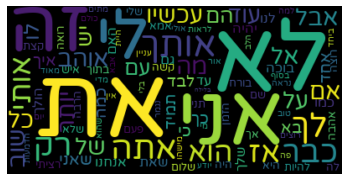

Most 'important' tokens of Eyal Golan (tf-idf representation):
['את', 'אני', 'לי', 'לך', 'לא', 'רק', 'אותך', 'כל', 'זה', 'אל', 'מה', 'איך', 'כמו', 'הלב', 'אם', 'הכל', 'שלי', 'כבר', 'אלייך', 'עוד', 'שאת', 'של', 'על', 'אוהב', 'אותי', 'גם', 'רוצה', 'יש', 'איתך', 'אין', 'אהבה', 'שלך', 'תמיד', 'שוב', 'עכשיו', 'כמה', 'אז', 'כי', 'היא', 'יום', 'עלייך', 'להיות', 'בך', 'לבד', 'בי', 'הלילה', 'היום', 'יכול', 'תגידי', 'יפה', 'אלי', 'עד', 'יודע', 'לה', 'אולי', 'עם', 'שלא', 'תני', 'מי', 'כאן', 'כולם', 'אחד', 'כשאת', 'העולם', 'איתי', 'הוא', 'בכל', 'בלב', 'בלעדייך', 'שאני', 'בעולם', 'יותר', 'אותה', 'פה', 'יודעת', 'היית', 'קצת', 'פתאום', 'אחת', 'או', 'חיי', 'בלילות', 'כך', 'הזמן', 'קשה', 'החיים', 'טוב', 'לו', 'מכל', 'ליבך', 'רציתי', 'בואי', 'כואב', 'תלכי', 'חלום', 'לאהוב', 'עלי', 'הייתי', 'אלוהים', 'בין']


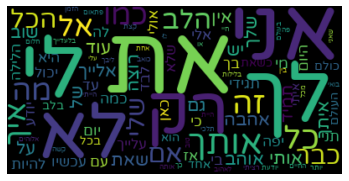

In [46]:
geffen_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אביב גפן"].tolist()]
geffen_tfidf_by_words = geffen_tfidf.mean(axis=0)
geffen_tfidf_inx = np.argsort(geffen_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Aviv Geffen (tf-idf representation):")
print([vocabulary[l] for l in geffen_tfidf_inx[::-1]])
tfidf_text= ""
for w in geffen_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*geffen_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

golan_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אייל גולן"].tolist()]
golan_tfidf_by_words = golan_tfidf.mean(axis=0)
golan_tfidf_inx = np.argsort(golan_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Eyal Golan (tf-idf representation):")
print([vocabulary[l] for l in golan_tfidf_inx[::-1]])
tfidf_text= ""
for w in golan_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*golan_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The same happens with
`יהודה פוליקר` and `משה פרץ`
`יהודית רביץ` and `זהבה בן`
`מאיר אריאל` and `ליאור נרקיס`
The pronounces (`את`,`אני`,`אתה`,etc.) the direct object marker (`אֵת`) and other syntax words and markers *take over* the vocabulary of most artists, even with tf-idf.
It is common for some NLP-tasks to remove the so called "Stop-Words" from the texts representations for this exact reason - this will be very useful with kNN.
We will discard the most common words using the BoW representation.

In [47]:
from script02 import stop_words
vocabulary = list(set(vocabulary) - set(stop_words))
print(f"Vocabulary length is: {len(vocabulary)}")
vectorizer_bow = CountVectorizer(vocabulary=vocabulary)
BoW_train = vectorizer_bow.fit_transform(train_df.lyrics)
print(f"The size of the vocabulary is indeed: {len(vectorizer_bow.get_feature_names_out())}")
vectorizer_sow = CountVectorizer(vocabulary=vocabulary, binary=True)
SoW_train = vectorizer_sow.fit_transform(train_df.lyrics)
vectorizer_tfidf = TfidfVectorizer(vocabulary=vocabulary,sublinear_tf=True)
tfidf_train = vectorizer_tfidf.fit_transform(train_df.lyrics)
bow_by_words = BoW_train.sum(axis=0)
sow_by_words = SoW_train.sum(axis=0)
tfidf_by_words = tfidf_train.mean(axis=0)
bow_inx = np.argsort(bow_by_words).tolist()[0][-k_best_words:]
sow_inx = np.argsort(sow_by_words).tolist()[0][-k_best_words:]
tfidf_inx = np.argsort(tfidf_by_words).tolist()[0][-k_best_words:]

Vocabulary length is: 62000
The size of the vocabulary is indeed: 62000


And now it's much better:

Most 'important' tokens of Yehuda Poliker (tf-idf representation):
['לך', 'כבר', 'אוהב', 'עכשיו', 'עוד', 'שאני', 'לבד', 'תמיד', 'אחד', 'כמה', 'בא', 'שאת', 'בוכה', 'האם', 'הולך', 'קשה', 'אהבה', 'פעם', 'רוצה', 'הזמן', 'תני', 'קצת', 'שלא', 'רציתי', 'שלום', 'איש', 'אמא', 'בורח', 'רואה', 'לראות', 'הרבה', 'בסוף', 'טוב', 'עניין', 'רוצים', 'מתים', 'מישהו', 'יודע', 'הלב', 'היית', 'נראה', 'אור', 'הדמעות', 'מאוד', 'אבא', 'שהוא', 'ביחד', 'נגמר', 'יום', 'גדול', 'בלילה', 'היום', 'אלי', 'האור', 'תראי', 'נהיה', 'חוזר', 'הולכת', 'עצוב', 'יפה', 'למות', 'כולנו', 'זמן', 'לנצח', 'הכל', 'ממנטו', 'דבר', 'יודעת', 'ילד', 'חבר', 'אלוהים', 'הכי', 'להציל', 'בי', 'לחלום', 'לעולם', 'אנ', 'עלייך', 'הכאב', 'פתאום', 'אנשים', 'תשכח', 'החוף', 'לאהוב', 'ליבך', 'אנו', 'בואי', 'מורי', 'לפעמים', 'מחר', 'צריך', 'יכולתי', 'לישון', 'שזה', 'בכל', 'שר', 'אמרת', 'הים', 'כמעט', 'חזק']


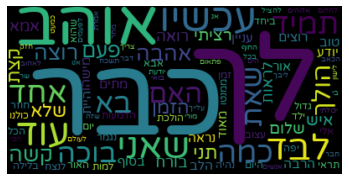

Most 'important' tokens of Eyal Golan (tf-idf representation):
['לך', 'הלב', 'הכל', 'כבר', 'אלייך', 'עוד', 'שאת', 'אוהב', 'רוצה', 'אהבה', 'תמיד', 'כמה', 'עכשיו', 'יום', 'עלייך', 'לבד', 'בך', 'הלילה', 'בי', 'היום', 'תגידי', 'יפה', 'יודע', 'אלי', 'שלא', 'תני', 'אחד', 'כשאת', 'העולם', 'בכל', 'בלב', 'בלעדייך', 'שאני', 'בעולם', 'יודעת', 'היית', 'קצת', 'אחת', 'פתאום', 'חיי', 'בלילות', 'הזמן', 'קשה', 'החיים', 'טוב', 'מכל', 'רציתי', 'ליבך', 'כואב', 'בואי', 'תלכי', 'לאהוב', 'חלום', 'הייתי', 'חושב', 'אלוהים', 'לילה', 'הכי', 'בשבילי', 'מחכה', 'אישה', 'ממך', 'יושב', 'בית', 'ביחד', 'לעולם', 'ימים', 'אהבתי', 'תחזרי', 'זו', 'בלילה', 'הזה', 'מילים', 'מרגיש', 'מאוהב', 'רוקדת', 'אוהבת', 'נגמר', 'הנשמה', 'לומר', 'כה', 'חשבתי', 'נשאר', 'אומר', 'תדעי', 'האהבה', 'שיש', 'דבר', 'קורא', 'בסוף', 'פזמון', 'ידעתי', 'ללב', 'עובר', 'חזק', 'ילדה', 'אמרת', 'בשבילך', 'מילה', 'ים']


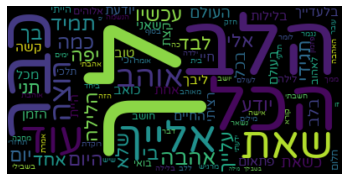

In [48]:
geffen_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אביב גפן"].tolist()]
geffen_tfidf_by_words = geffen_tfidf.mean(axis=0)
geffen_tfidf_inx = np.argsort(geffen_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Yehuda Poliker (tf-idf representation):")
print([vocabulary[l] for l in geffen_tfidf_inx[::-1]])
tfidf_text= ""
for w in geffen_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*geffen_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

golan_tfidf = tfidf_train[train_df.index[train_df['artist'] == "אייל גולן"].tolist()]
golan_tfidf_by_words = golan_tfidf.mean(axis=0)
golan_tfidf_inx = np.argsort(golan_tfidf_by_words).tolist()[0][-k_best_words:]

print("Most 'important' tokens of Eyal Golan (tf-idf representation):")
print([vocabulary[l] for l in golan_tfidf_inx[::-1]])
tfidf_text= ""
for w in golan_tfidf_inx:
    tfidf_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*golan_tfidf_by_words[0,w])

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w'],font_step=3).generate(tfidf_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Being Normal
For the BoW and SoW representations the vectors should be normalized.
We used the StandardScaler for standardize features by removing the mean and scaling to unit variance.
The with_mean var is set to false because centering a sparce matrix results in building a dense matrix which in common use cases is likely to be too large to fit in memory.

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(BoW_train)
BoW_train = scaler.transform(BoW_train)
scaler = StandardScaler(with_mean=False)
scaler.fit(SoW_train)
SoW_train = scaler.transform(SoW_train)

## Keep Your Distance
How can we define how 'close' two songs are?
In order to do so we will need a method for measuring the distance between two texts based on their representations.
We will use three, and choose one using the validation set:
* [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)
* [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)
* [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity)

In [50]:
from scipy.spatial import distance
songs_to_comapre = ["זיקוקים","שמים","לא יכול להוריד ממך את העיניים"]
distance_to_use = {"Hamming distance":distance.hamming, "Euclidean distance":distance.euclidean, "cosine distance": distance.cosine}
for d_n,d_f in distance_to_use.items():
    for s1 in range(len(songs_to_comapre)):
        for s2 in range(s1 + 1,len(songs_to_comapre)):
            first_song = train_df.index[train_df['song_name'] == songs_to_comapre[s1]]
            second_song = train_df.index[train_df['song_name'] == songs_to_comapre[s2]]
            print(f"The {d_n} between {songs_to_comapre[s1]} and {songs_to_comapre[s2]} using the tf-idf representation:")
            print(d_f(tfidf_train[first_song].toarray()[0],tfidf_train[second_song].toarray()[0]))

The Hamming distance between זיקוקים and שמים using the tf-idf representation:
0.0017258064516129032
The Hamming distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.0019516129032258064
The Hamming distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.0020806451612903226
The Euclidean distance between זיקוקים and שמים using the tf-idf representation:
1.4114382284279023
The Euclidean distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
1.412248764188124
The Euclidean distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
1.404246286708719
The cosine distance between זיקוקים and שמים using the tf-idf representation:
0.9960789363338475
The cosine distance between זיקוקים and לא יכול להוריד ממך את העיניים using the tf-idf representation:
0.9972232859754417
The cosine distance between שמים and לא יכול להוריד ממך את העיניים using the tf-idf re

## A story of One-vs-All, kNN, Eyal Golan and Aviv Geffen
We will now build our first classifier!
Our first classifier will be "One-vs-All"; Our job is to differentiate between songs of one particular artist and all the rest.
We will actually build two classifiers, [one for Eyal Golan and one for Aviv Geffen](https://he.wikipedia.org/wiki/%D7%90%D7%91%D7%99%D7%91_%D7%90%D7%95_%D7%90%D7%99%D7%99%D7%9C).

In [51]:
golan_train = train_df.copy()
golan_train['artist'] = (golan_train['artist']=="אייל גולן")
geffen_train = train_df.copy()
geffen_train['artist'] = (geffen_train['artist']=="אביב גפן")

### How sure are you?
We want a way to evaluate how accurate our model is.
One naive way is the accuracy metric:

$\frac{#truePositive+#trueNegative}{#allSongs}$

In [52]:
def naive_accuracy(X, y, model):
    return (model(X) == y).sum() / y.size

Why naive?
Most songs are not of one specific artist and therefore a model which always returns "False" should get high accuracy rate:

In [53]:
def false_model(X):
    return np.full(X.shape[0], False)


X = BoW_train
y = np.array(geffen_train['artist'])
print(f"Accuracy rate of False-Model for Aviv Geffen: {naive_accuracy(X,y,false_model)}")
y = np.array(golan_train['artist'])
print(f"Accuracy rate of False-Model for Eyal Golan: {naive_accuracy(X,y,false_model)}")

Accuracy rate of False-Model for Aviv Geffen: 0.9851694915254238
Accuracy rate of False-Model for Eyal Golan: 0.9719868173258004


Two other metrics are the *Precision* and *Recall*:

$Precision = \frac{#truePositive}{#truePositive+#falsePositive};

Recall= \frac{#truePositive}{#truePositive+#falseNegative}$

In [54]:
def true_model(X):
    return np.full(X.shape[0], True)

from sklearn.metrics import precision_score, recall_score

y = np.array(geffen_train['artist'])
print(f"Precision score of False-Model for Aviv Geffen: {precision_score(y,false_model(X))}")
print(f"Recall score of False-Model for Aviv Geffen: {recall_score(y,false_model(X))}")
print(f"Precision score of True-Model for Aviv Geffen: {precision_score(y,true_model(X))}")
print(f"Recall score of True-Model for Aviv Geffen: {recall_score(y,true_model(X))}")
y = np.array(golan_train['artist'])
print(f"Precision score of False-Model for Eyal Golan: {precision_score(y,false_model(X))}")
print(f"Recall score of False-Model for Eyal Golan: {recall_score(y,false_model(X))}")
print(f"Precision score of True-Model for Eyal Golan: {precision_score(y,true_model(X))}")
print(f"Recall score of True-Model for Eyal Golan: {recall_score(y,true_model(X))}")

Precision score of False-Model for Aviv Geffen: 0.0
Recall score of False-Model for Aviv Geffen: 0.0
Precision score of True-Model for Aviv Geffen: 0.014830508474576272
Recall score of True-Model for Aviv Geffen: 1.0
Precision score of False-Model for Eyal Golan: 0.0
Recall score of False-Model for Eyal Golan: 0.0
Precision score of True-Model for Eyal Golan: 0.028013182674199624
Recall score of True-Model for Eyal Golan: 1.0


We will use the F1 score, a combination of Precision and Recall
$F1 = 2\cdot\frac{Precision\cdot Recall}{Precision+Recall}$

In [55]:
from sklearn.metrics import f1_score
y = np.array(geffen_train['artist'])
print(f"F1 score of False-Model for Aviv Geffen: {f1_score(y,false_model(X))}")
print(f"F1 score of True-Model for Aviv Geffen: {f1_score(y,true_model(X))}")
y = np.array(golan_train['artist'])
print(f"F1 score of False-Model for Eyal Golan: {f1_score(y,false_model(X))}")
print(f"F1 score of True-Model for Eyal Golan: {f1_score(y,true_model(X))}")

F1 score of False-Model for Aviv Geffen: 0.0
F1 score of True-Model for Aviv Geffen: 0.029227557411273485
F1 score of False-Model for Eyal Golan: 0.0
F1 score of True-Model for Eyal Golan: 0.054499656514769866


## kNN
We are ready for our greed search for the kNN model.
We will use cross validation with `cv` value of 3.
We will check each one of the artists, for each one of the word representations and for each value of k between 1 and 25.
We will check two metrics, cosine and euclidean, and for the SoW representation we will also try the manhattan distance (equivalent to hamming in SoW representation).

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [195]:
X = BoW_train
y = np.array(geffen_train['artist'])
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Geffen, Bag-of-Words Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Geffen, Bag-of-Words Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 9.538239538239536


In [45]:
X = SoW_train
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Geffen, Set-of-Words Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Geffen, Set-of-Words Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 5.779339219831695


In [46]:
X = tfidf_train
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Geffen, tf-idf Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Geffen, tf-idf Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 8.926639944009672


In [47]:
X = BoW_train
y = np.array(golan_train['artist'])
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan, Bag-of-Words Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan, Bag-of-Words Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 6.16944325245831


In [48]:
X = SoW_train
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan, Set-of-Words Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan, Set-of-Words Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 5.779339219831695


In [49]:
X = tfidf_train
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean','cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan, tf-idf Representation")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan, tf-idf Representation
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 8.926639944009672


## Houston, we have a problem
It appears that for Aviv Geffen the best representation is the Set-of-Word, the cosine distance function, and k = 1.
The f1 score was 9.733893557422968.
For Eyal Golan the best representation is the tf-idf, the cosine distance function, and k = 1.
The f1 score was 9.752325872268225.
For Aviv Geffen we got a score which was 3.33 times better than the "always-true-classifier".
For Eyal Golan we got a score which was 1.79 times better than the "always-true-classifier".
Well, is it any good? Not so much...
It seems that even with all of our tweaks and tricks kNN failed to classify songs by Aviv Geffen and Eyal Golan.
Our guess?
#### The dimension is too d*mn big!

## 62000D movie
We will try to reduce the dimension of the data using PCA, t-SNE and UMAP.

### Embedding space exploration
We will now explore three different dimensionality reduction techniques:
1. PCA (Principal Component Analysis) - a linear dimensionality reduction technique finding orthogonal components with the highest variance of the data, encouraging the components to be linearly uncorrelated.

2. t-SNE (t-distributed Stochastic Neighbor Embedding) - a non-linear dimensionality reduction where we build a probability distribution over pairs of high-dimensional objects and another probability distribution over the corresponding low-dimensional points, and we minimize the Kullback–Leibler divergence between the two distributions with respect to the locations of the low-dimensional points.

3. UMAP (Uniform Manifold Approximation and Projection) - a non-linear dimensionality reduction technique based on manifold learning and algebraic topology. It is a generalization of t-SNE, but it is faster and preserves more of the global structure of the data points. For further reading, consider [this paper](https://arxiv.org/abs/1802.03426).

In [51]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [52]:
artists_to_project = ["אייל גולן", "אביב גפן", "יהודית רביץ"]
songs_to_project = train_df['artist'].isin(artists_to_project)
labels = [artists_to_project.index(a) for a in train_df['artist'][songs_to_project]]
cmap = plt.cm.get_cmap('Spectral', len(artists_to_project))

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP(n_components=2)

pca_bow = pca.fit_transform(BoW_train[songs_to_project].toarray())
tsne_bow = tsne.fit_transform(BoW_train[songs_to_project].toarray())
umap_bow = umap.fit_transform(BoW_train[songs_to_project].toarray())
pca_sow = pca.fit_transform(SoW_train[songs_to_project].toarray())
tsne_sow = tsne.fit_transform(SoW_train[songs_to_project].toarray())
umap_sow = umap.fit_transform(SoW_train[songs_to_project].toarray())
pca_tfidf = pca.fit_transform(tfidf_train[songs_to_project].toarray())
tsne_tfidf = tsne.fit_transform(tfidf_train[songs_to_project].toarray())
umap_tfidf = umap.fit_transform(tfidf_train[songs_to_project].toarray())

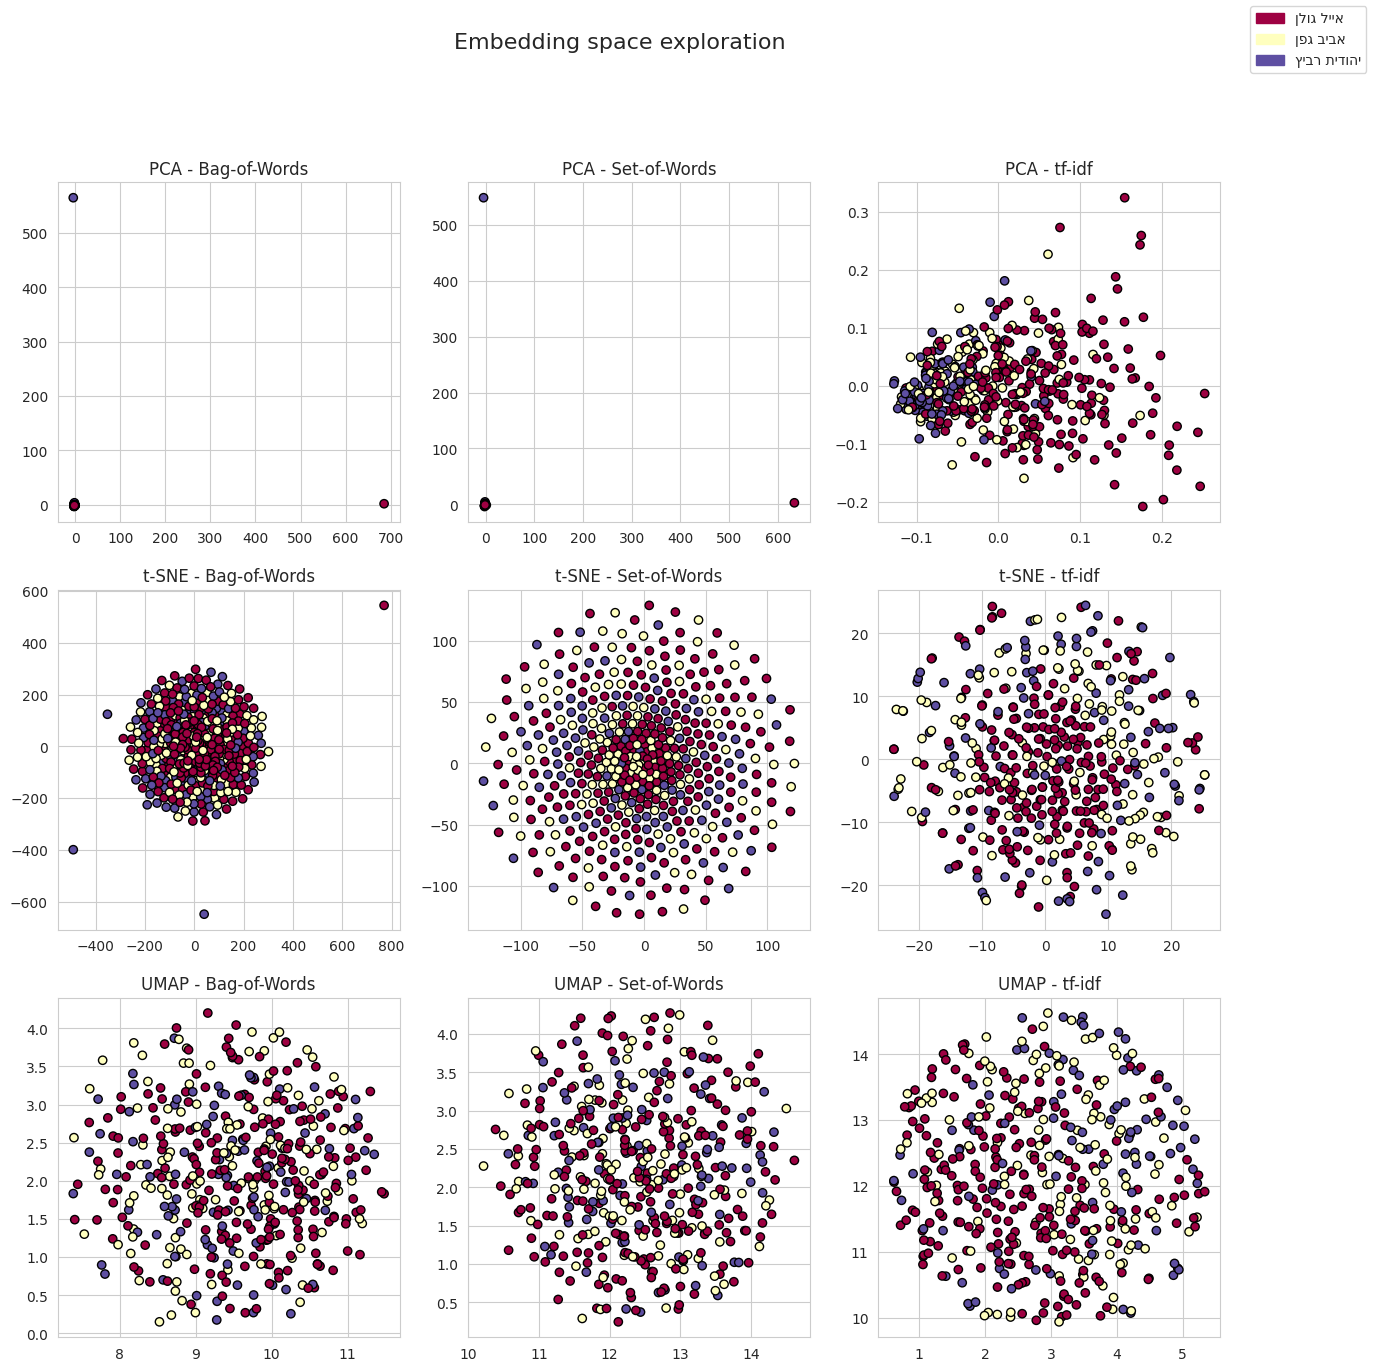

In [68]:
from matplotlib import patches as mpatches

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Embedding space exploration', fontsize=16)
fig.legend(handles=[mpatches.Patch(color=cmap(i), label=artists_to_project[i][::-1]) for i in range(len(artists_to_project))], loc='upper right')
axes[0, 0].set_title('PCA - Bag-of-Words')
axes[0, 0].scatter(pca_bow[:, 0], pca_bow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 1].set_title('PCA - Set-of-Words')
axes[0, 1].scatter(pca_sow[:, 0], pca_sow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[0, 2].set_title('PCA - tf-idf')
axes[0, 2].scatter(pca_tfidf[:, 0], pca_tfidf[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 0].set_title('t-SNE - Bag-of-Words')
axes[1, 0].scatter(tsne_bow[:, 0], tsne_bow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 1].set_title('t-SNE - Set-of-Words')
axes[1, 1].scatter(tsne_sow[:, 0], tsne_sow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[1, 2].set_title('t-SNE - tf-idf')
axes[1, 2].scatter(tsne_tfidf[:, 0], tsne_tfidf[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[2, 0].set_title('UMAP - Bag-of-Words')
axes[2, 0].scatter(umap_bow[:, 0], umap_bow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[2, 1].set_title('UMAP - Set-of-Words')
axes[2, 1].scatter(umap_sow[:, 0], umap_sow[:, 1], c=labels, cmap=cmap, edgecolor='k')
axes[2, 2].set_title('UMAP - tf-idf')
axes[2, 2].scatter(umap_tfidf[:, 0], umap_tfidf[:, 1], c=labels, cmap=cmap, edgecolor='k')

plt.show()

### Training kNN on the reduced dimension data
We will now reduce the dimension of the data using PCA, t-SNE and UMAP, and then train kNN on the reduced dimension data.
For this specific version of the notebook we did not have enough resources to run the TSNE and umap more than a few times (the output was not captured), but you are welcome to run them yourself and witness the results!

In [22]:
pca = PCA(n_components=25) # can either give a number of components or a variance ratio
#tsne = TSNE(n_components=3)
#umap = UMAP(n_components=3)

pca_bow = pca.fit_transform(BoW_train.toarray())
print("[*] pca_bow")
print(f"PCA components: {pca.n_components_}")
print(f"PCA explained variance: {pca.explained_variance_ratio_}")
#tsne_bow = tsne.fit_transform(BoW_train.toarray())
#print("[*] tsne_bow")
#umap_bow = umap.fit_transform(BoW_train.toarray())
#print("[*] umap_bow")
pca_sow = pca.fit_transform(SoW_train.toarray())
print("[*] pca_sow")
print(f"PCA components: {pca.n_components_}")
print(f"PCA explained variance: {pca.explained_variance_ratio_}")
#tsne_sow = tsne.fit_transform(SoW_train.toarray())
#print("[*] tsne_sow")
#umap_sow = umap.fit_transform(SoW_train.toarray())
#print("[*] umap_sow")
pca_tfidf = pca.fit_transform(tfidf_train.toarray())
print("[*] pca_tfidf")
print(f"PCA components: {pca.n_components_}")
print(f"PCA explained variance: {pca.explained_variance_ratio_}")
#tsne_tfidf = tsne.fit_transform(tfidf_train.toarray())
#print("[*] tsne_tfidf")
#umap_tfidf = umap.fit_transform(tfidf_train.toarray())
#print("[*] umap_tfidf")

[*] pca_bow
PCA components: 25
PCA explained variance: [0.00211578 0.00176087 0.00140473 0.00139989 0.00130937 0.00128782
 0.00124144 0.00117548 0.00113725 0.00104999 0.00101596 0.00098325
 0.00097157 0.0009538  0.00094772 0.0009335  0.00091606 0.00090661
 0.00090028 0.00088554 0.00087101 0.00085147 0.00084599 0.00082382
 0.00080778]
[*] pca_sow
PCA components: 25
PCA explained variance: [0.00214266 0.00175913 0.00143356 0.00136648 0.00134436 0.00128866
 0.00120418 0.00120275 0.00113579 0.00106665 0.00105128 0.00099704
 0.00098119 0.0009738  0.0009702  0.00095922 0.00095836 0.00091449
 0.00090355 0.00087417 0.00085906 0.00083562 0.00082518 0.00082086
 0.00081763]
[*] pca_tfidf
PCA components: 25
PCA explained variance: [0.00299003 0.00188831 0.00146054 0.00137676 0.00129863 0.00127786
 0.00123209 0.0011685  0.00114771 0.00112127 0.00108186 0.0010685
 0.00105318 0.00103481 0.00101821 0.0010099  0.00100604 0.00096637
 0.00096139 0.00095367 0.00094875 0.00093196 0.00091532 0.00091125
 0.0

#### Aviv Gefen

In [25]:
y = np.array(geffen_train['artist'])
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")

In [26]:
X = pca_bow
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Gefen - Bag-of-Words - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Gefen - Bag-of-Words - PCA
Best Params: {'metric': 'euclidean', 'n_neighbors': 1}
f1 score: 3.3738748024462315


In [56]:
"""
X = tsne_bow
knn_gscv.fit(X, y)
print("Aviv Gefen - Bag-of-Words - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_bow\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - Bag-of-Words - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [28]:
"""
X = umap_bow
knn_gscv.fit(X, y)
print("Aviv Gefen - Bag-of-Words - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_bow\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - Bag-of-Words - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [29]:
X = pca_sow
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine', 'manhattan']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Gefen - Set-of-Words - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Gefen - Set-of-Words - PCA
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 4.351851851851852


In [30]:
"""
X = tsne_sow
knn_gscv.fit(X, y)
print("Aviv Gefen - Set-of-Words - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_sow\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - Set-of-Words - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [31]:
"""
X = umap_sow
knn_gscv.fit(X, y)
print("Aviv Gefen - Set-of-Words - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_sow\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - Set-of-Words - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [32]:
X = pca_tfidf
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Aviv Gefen - tf-idf - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Aviv Gefen - tf-idf - PCA
Best Params: {'metric': 'cosine', 'n_neighbors': 1}
f1 score: 1.82648401826484


In [33]:
"""
X = tsne_tfidf
knn_gscv.fit(X, y)
print("Aviv Gefen - tf-idf - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_tfidf\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - tf-idf - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [34]:
"""
X = umap_tfidf
knn_gscv.fit(X, y)
print("Aviv Gefen - tf-idf - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_tfidf\nknn_gscv.fit(X, y)\nprint("Aviv Gefen - tf-idf - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

#### Eyal Golan

In [35]:
y = np.array(golan_train['artist'])


In [36]:
X = pca_bow
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan - Bag-of-Words - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan - Bag-of-Words - PCA
Best Params: {'metric': 'euclidean', 'n_neighbors': 1}
f1 score: 4.586893480399772


In [37]:
"""
X = tsne_bow
knn_gscv.fit(X, y)
print("Eyal Golan - Bag-of-Words - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_bow\nknn_gscv.fit(X, y)\nprint("Eyal Golan - Bag-of-Words - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [38]:
"""
X = umap_bow
knn_gscv.fit(X, y)
print("Eyal Golan - Bag-of-Words - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_bow\nknn_gscv.fit(X, y)\nprint("Eyal Golan - Bag-of-Words - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [39]:
X = pca_sow
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine', 'manhattan']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan - Set-of-Words - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan - Set-of-Words - PCA
Best Params: {'metric': 'euclidean', 'n_neighbors': 1}
f1 score: 6.107081239689196


In [40]:
"""
X = tsne_sow
knn_gscv.fit(X, y)
print("Eyal Golan - Set-of-Words - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_sow\nknn_gscv.fit(X, y)\nprint("Eyal Golan - Set-of-Words - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [41]:
"""
X = umap_sow
knn_gscv.fit(X, y)
print("Eyal Golan - Set-of-Words - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_sow\nknn_gscv.fit(X, y)\nprint("Eyal Golan - Set-of-Words - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [42]:
X = pca_tfidf
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'metric': ['euclidean', 'cosine']}
knn_gscv = GridSearchCV(knn, param_grid, cv=3,scoring="f1")
grid_search = knn_gscv.fit(X, y)
print("Eyal Golan - tf-idf - PCA")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")

Eyal Golan - tf-idf - PCA
Best Params: {'metric': 'euclidean', 'n_neighbors': 1}
f1 score: 6.712727765359344


In [43]:
"""
X = tsne_tfidf
knn_gscv.fit(X, y)
print("Eyal Golan - tf-idf - t-SNE")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = tsne_tfidf\nknn_gscv.fit(X, y)\nprint("Eyal Golan - tf-idf - t-SNE")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

In [44]:
"""
X = umap_tfidf
knn_gscv.fit(X, y)
print("Eyal Golan - tf-idf - UMAP")
print(f"Best Params: {grid_search.best_params_}")
print(f"f1 score: {100*grid_search.best_score_}")
"""

'\nX = umap_tfidf\nknn_gscv.fit(X, y)\nprint("Eyal Golan - tf-idf - UMAP")\nprint(f"Best Params: {grid_search.best_params_}")\nprint(f"f1 score: {100*grid_search.best_score_}")\n'

### PCA analysis
We did not to find any significant improvement by using PCA.
In our opinion, reducing from a 62000 dimension vector to a 25 dimension vector, using only linear combinations of the original features, is not enough to capture the essence of the data, and also PCA is very sensitive to outliers, as we could see in the visualization from earlier.
We would be happy to use t-SNE or UMAP, for dimensionality reduction, but we did not have the required computational resources to do so.

In the next notebook we will try to use a dense representation of the lyrics, using a pre-trained word embedding model, and then use dimensionality reduction techniques to reduce the dimensionality of the data. We expect to see better results, considering the fact that we start with fewer dimensions.